wroking from accuracy 54 base, trying to tune learning_rate


In [2]:


import os
import glob
import random
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader 
from torch.optim.lr_scheduler import StepLR
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


In [3]:
class CNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[32, 64, 128, 256, 512, 1024, 2048], img_w=100, img_h=100, num_classes=102):
        super(CNN, self).__init__()
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        for i in range(len(num_out_ch)):
            in_ch = num_channels if i == 0 else num_out_ch[i - 1]
            out_ch = num_out_ch[i]
            self.convs.append(nn.Conv2d(in_ch, out_ch, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
            self.bns.append(nn.BatchNorm2d(out_ch))
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear((img_w // 2**(len(num_out_ch) // 2)) * (img_h // 2**(len(num_out_ch) // 2)) * num_out_ch[-1], num_classes)
    
    def forward(self, x):
        for i in range(len(self.convs)):
            x = F.relu(self.bns[i](self.convs[i](x)))
            if (i + 1) % 2 == 0:
                x = self.pool(x)
        
        x = self.fc(x.reshape(x.shape[0], -1))
        return x
model = CNN()
x = torch.randn(1, 3, 100, 100)
print(model(x).shape)
y = model(x)
print(y.shape)


torch.Size([1, 102])
torch.Size([1, 102])


In [4]:
# PARAMS
"""
NUM_CHANNELS 
[32, 64, 128] %28.39
[64, 128, 256] %30.41
[32, 64, 128, 256] %23.13
[64, 128, 256, 512] dont have enough memory to run lol
"""
# PARAMS
NUM_CHANNELS = [32, 64, 128] # number of output channels for each conv layer
IMG_W = 224   # image width
IMG_H = 224   # image height
NUM_CLASSES = 102 # number of classes (flowers)
BATCH_SIZE = 32 # batch size (number of images to process at once)
NUM_EPOCHS = 12 # number of epochs (times to run the training loop)
LEARNING_RATE = 0.0001 # learning rate

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available
print("RUNNING ON: ", device)

# model
# move model to device
model = CNN(num_channels=3, num_out_ch=NUM_CHANNELS, img_w=IMG_W, img_h=IMG_H, num_classes=NUM_CLASSES).to(device)


# loss and optimizer
criterion = nn.CrossEntropyLoss()

optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimiser, 
                   step_size=7, # period of learning rate decay
                   gamma=0.1 # decay factor
                )

RUNNING ON:  cuda


In [5]:
def count_parameters(model)->int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("MODEL HAS : ", count_parameters(model), " PARAMETERS")

MODEL HAS :  163868262  PARAMETERS


,image_path,image_label
0,./data/flowers-102/jpg\image_00001.jpg,76
1,./data/flowers-102/jpg\image_00002.jpg,76
2,./data/flowers-102/jpg\image_00003.jpg,76
3,./data/flowers-102/jpg\image_00004.jpg,76
4,./data/flowers-102/jpg\image_00005.jpg,76
...,...,...
8184,./data/flowers-102/jpg\image_08185.jpg,61
8185,./data/flowers-102/jpg\image_08186.jpg,61
8186,./data/flowers-102/jpg\image_08187.jpg,61
8187,./data/flowers-102/jpg\image_08188.jpg,61


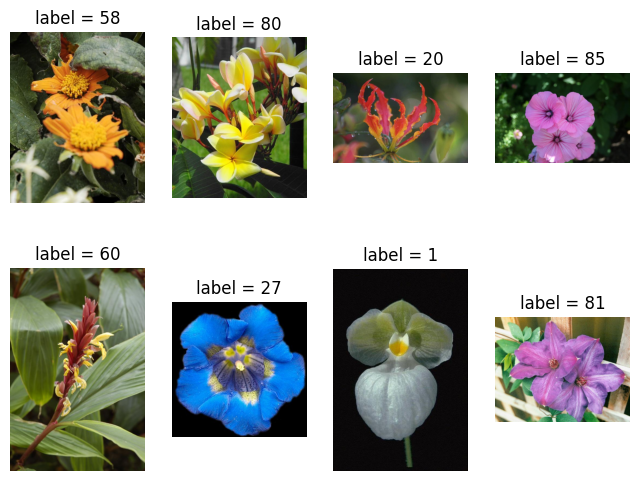

In [6]:
data_path = "./data/flowers-102/jpg" # path to data
labels_path = "./data/flowers-102/imagelabels.mat" # path to labels
label_arr = scp.loadmat(labels_path)['labels'] # load labels
label_arr -= 1 # subtract 1 from each label (labels are 1-indexed)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 6)) # create figure
image_num = random.sample(range(1, 8189), 8) # get 8 random image numbers
for i in range(2): # loop through rows
    for j in range(4): # loop through columns
        image = skio.imread(os.path.join(data_path, f"image_{image_num[i * 4 + j]:05}.jpg")) # read image
        ax[i, j].imshow(image)  # plot image
        ax[i, j].set_title(f"label = {label_arr[0, image_num[i * 4 + j] - 1]}") # set title
        ax[i, j].axis('off') # turn off axis
labels_list = list(set(label_arr[:, 0])) # get list of unique labels
image_paths = sorted(glob.glob(os.path.join(data_path, "*.jpg"))) # get list of image paths
metadata = pd.DataFrame({
    "image_path": image_paths, 
    "image_label": label_arr[0, :].tolist() 
}) # create dataframe with image paths and labels
metadata

In [7]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0)) # Convert the tensor to a NumPy array and transpose to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406]) # Mean used in normalization
    std = np.array([0.229, 0.224, 0.225]) # Standard deviation used in normalization
    img = std * img + mean # Unnormalize the image
    img = np.clip(img, 0, 1) # Clip values to the valid range [0, 1]
    plt.imshow(img) # Display the image


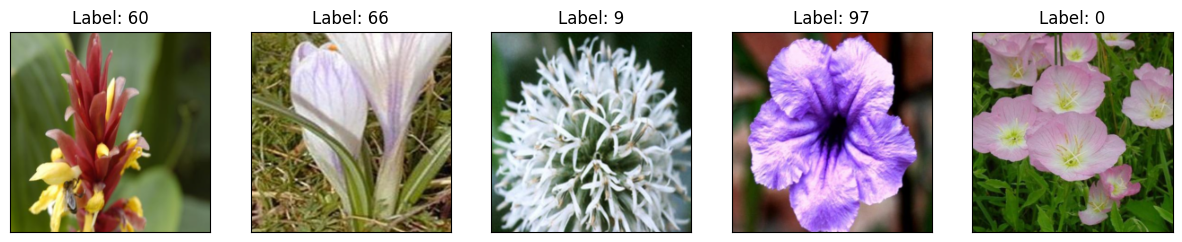

In [8]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # resize the image to a random scale + aspect ratio and crop to 224x224 (helps model generalise
    transforms.RandomHorizontalFlip(), # randomly flip the image horizontally (50/50 chance) 
    transforms.ToTensor(), # convert image from PIL to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalise the image with mean and standard deviation
])
valid_transforms = transforms.Compose([
    transforms.Resize(256), # resize the image to 256x256
    transforms.CenterCrop(224), # crop the image to 224x224 (center)
    transforms.ToTensor(), # convert image from PIL to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalise the image with mean and standard deviation
])
test_transform = transforms.Compose([
    transforms.Resize(256), # resize the image to 256x256
    transforms.CenterCrop(224), # crop the image to 224x224 (center)
    transforms.ToTensor(), # convert image from PIL to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalise the image with mean and standard deviation
])

train_set = torchvision.datasets.Flowers102(root="data", download=True, transform=transform)
test_set = torchvision.datasets.Flowers102(root="data", download=True, split="test", transform=test_transform)
val_set = torchvision.datasets.Flowers102(root="data", download=True, split="val", transform=valid_transforms)
num_images = 5 # Number of images to display

fig = plt.figure(figsize=(15, 5))

for i in range(num_images):
    idx = np.random.randint(len(train_set)) # Randomly select an index from the train set
    img, label = train_set[idx] # Get the image and label at the selected index
    ax = fig.add_subplot(1, num_images, i + 1, xticks=[], yticks=[])
    imshow(img) # Display the image
    ax.set_title(f"Label: {label}") # Set the title to show the label

plt.show()

In [9]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
from PIL import Image

def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return True
    except (IOError, SyntaxError):
        return False

valid_image_paths = [path for path in image_paths if is_valid_image(path)]
print(f"Total valid images: {len(valid_image_paths)}")

Total valid images: 8189


In [10]:
def check_accuracy(loader, model):
    correct = 0 
    samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device) # move images to device
            y = y.to(device) # move labels to device
            y_hat = model(x) # get predictions
            _, predictions = y_hat.max(1) # get predictions
            correct += (predictions == y).sum() # add number of correct predictions
            samples += predictions.size(0) # add number of samples
    print(f"Accuracy: {correct}/{samples}: %{correct/samples*100:.2f}") # print accuracy
    model.train() # set model back to train mode

for epoch in range(NUM_EPOCHS):
    running_loss = 0
    val_running_loss = 0
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        y_hat = model(x)
        loss = criterion(y_hat, y)
        running_loss += loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            y_val_hat = model(x_val)
            val_loss = criterion(y_val_hat, y_val)
            val_running_loss += val_loss

    model.train()

    scheduler.step()
    print(f"Epoch {epoch+1} of {NUM_EPOCHS}, Train Loss: {running_loss}, Val Loss: {val_running_loss}")
    check_accuracy(val_loader, model)

In [ ]:
import time
print("Saving model...")
torch.save(model.state_dict(), f"./models/model_{time.time()}.pth")
print("Model saved!")
check_accuracy(test_loader, model) # check accuracy on test set (unseen data)